TO DO: 

- check that now supposed to be no overlap between fragment link and all structures - should i take out structures that are similar to fragments? 
- clustering
- try aligning one query mol to fragment cloud
- brute force approach
- compare to RANSAC, ICP
- quantify
- substructure matching

FRAGMENTS: 
                                    
- get SD files                      
- convert to mol objects            
- get pharmacophore points          
                                    
QUERY MOLECULES:                    
                                    
- get SD files
- convert to mol objects
- get conformers
- get pharmacophore points

FUNCTION TO GET ALL SDF IN DIRECTORY

In [23]:
import os
from rdkit import Chem


def get_sdfs(dir_name):
    
    sdf_files = []
    filenames = []

    # collect sdf files from dirs
    for root, dirs, files in os.walk(dir_name):
        for file in files:
            if file.endswith(".sdf"):
                # ignore combined sdf file
                if 'Mpro_combined' not in file:
                    sdf_files.append(os.path.join(root, file))
                    filenames.append(file)

    return sdf_files, filenames


CONVERT SDF TO MOL OBJECTS IN RDKIT

https://www.rdkit.org/docs/GettingStartedInPython.html

In [24]:
# get mol object for each sdf file

def sdf_to_mol(sdf_file_list):
   
   mols = []
   for sdf_file in sdf_file_list:
      with Chem.SDMolSupplier(sdf_file) as suppl:
         for mol in suppl:
            if mol is None: continue
            mols.append(mol)

   return mols


EXTRACT PHARMACOPHORES AND COORDINATES
http://rdkit.blogspot.com/2017/11/using-feature-maps.html 

In [25]:
# code to generate pharmacophores
import numpy as np
from rdkit import RDConfig, Chem
from rdkit.Chem import AllChem
from collections import defaultdict

# feature factory defines set of pharmacophore features being used 
_FEATURES_FACTORY, _FEATURES_NAMES = [], []

def get_features_factory(features_names, resetPharmacophoreFactory=False):

    global _FEATURES_FACTORY, _FEATURES_NAMES

    if resetPharmacophoreFactory or (len(_FEATURES_FACTORY) > 0 and _FEATURES_FACTORY[-1] != features_names):
        _FEATURES_FACTORY.pop()
       # _FEATURES_FACTORY.pop() # NOTE repeated line?
    if len(_FEATURES_FACTORY) == 0:
        feature_factory = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))
        _FEATURES_NAMES = features_names
        if features_names is None:
            features_names = list(feature_factory.GetFeatureFamilies())

        _FEATURES_FACTORY.extend([feature_factory, features_names])

    return _FEATURES_FACTORY

In [26]:
# NOTE ask re conformers here vs for query mols

def getPharmacophoreCoords(mol, features_names=["Acceptor", "Donor", "Aromatic"], confId=-1):

    # find features of a molecule
    feature_factory, keep_featnames = get_features_factory(features_names)
    rawFeats = feature_factory.GetFeaturesForMol(mol, confId=confId)
    featsDict = defaultdict(list)
    idxsDict = defaultdict(list)

    for f in rawFeats:
        if f.GetFamily() in keep_featnames:
            featsDict[f.GetFamily()].append(np.array(f.GetPos(confId=f.GetActiveConformer())))
            idxsDict[f.GetFamily()].append(np.array(f.GetAtomIds()))

    new_feats_dict = {}
    for key in featsDict:
        new_feats_dict[key] = np.concatenate(featsDict[key]).reshape((-1,3))
    
    return new_feats_dict, idxsDict


SEPARATE PHARMACOPHORE DICT INTO COORDS FOR DONOR, ACCEPTOR, AROMATIC

In [27]:
# compute pharmacophores coordinates
# NOTE should change just to work for one molecule rather than looping through

def get_coords(mols):

    donor_coords = []
    acceptor_coords = []
    aromatic_coords = []

    for mol in mols:
        # .get() will just fill with None if key doesn't exist
        pharma_coords, __ = getPharmacophoreCoords(mol)
        donor_coord = pharma_coords.get('Donor')
        acceptor_coord = pharma_coords.get('Acceptor')
        aromatic_coord = pharma_coords.get('Aromatic')

        donor_coords.append(donor_coord)
        acceptor_coords.append(acceptor_coord)
        aromatic_coords.append(aromatic_coord)

    # remove None values
    donor_coords = [x for x in donor_coords if x is not None]
    acceptor_coords = [x for x in acceptor_coords if x is not None]
    aromatic_coords = [x for x in aromatic_coords if x is not None]

    if len(donor_coords) == 0:
        donor_coords = donor_coords
    else: 
        donor_coords = np.concatenate(donor_coords)
    
    if len(acceptor_coords) == 0:
        acceptor_coords = acceptor_coords
    else:
        acceptor_coords = np.concatenate(acceptor_coords)

    if len(aromatic_coords) == 0:
        aromatic_coords = aromatic_coords
    else:
        aromatic_coords = np.concatenate(aromatic_coords)

    return donor_coords, acceptor_coords, aromatic_coords


PLOT PHARMACOPHORE CLOUD

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_coords(donor_coords, acceptor_coords, aromatic_coords):
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')

    # visualize the 3D cloud of fragment pharmacophores. They are a good representation of the protein pocket.
    labels = ['Donor', 'Acceptor', 'Aromatic']
    for coords, label in zip([donor_coords, acceptor_coords, aromatic_coords], labels):
        if len(coords) != 0:
            ax.scatter3D(coords[:,0], coords[:,1], coords[:,2], label=label)

    plt.legend()
    plt.show()

    return

SETTING UP FRAGMENT POINT CLOUD

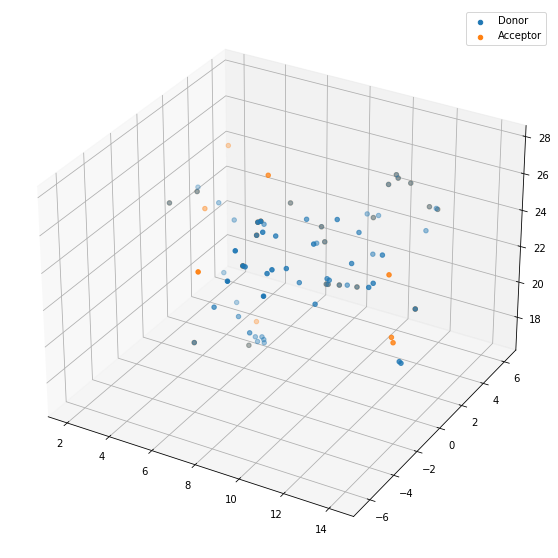

In [29]:
# run above functions
fragment_files, frag_filenames = get_sdfs('Mpro_fragments')
frag_mols = sdf_to_mol(fragment_files)
frag_donor_coords, frag_acceptor_coords, frag_aromatic_coords = get_coords(frag_mols)
plot_coords(frag_donor_coords, frag_acceptor_coords, frag_aromatic_coords)



- check against pdb fragments 

(unfinished) clustering

hierarchical clustering (agglomerative sklearn)

want to reduce the number of points

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

def cluster(data):

    model = AgglomerativeClustering(linkage='average', n_clusters=None, distance_threshold=1.5)
    model.fit_predict(data)
    pred = model.fit_predict(data)
    print("number of cluster found: {}".format(len(set(model.labels_))))
    print('cluster for each point: ', model.labels_)

    return pred




QUERY MOLECULES

- don't need coords for conformers if testing alignment because removing coords from the query mols anyway to test alignment..
- but will still need for ground truth? 
- do i need to remove query mols that are v similar to fragments? 


- need ground truth experimental conformer which comes from sdf with coordinates, can remove coordinates and then use for alignment, need ground truth to see performance of alignment algorithm
- could generate multiple conformers and see which is the best conformer that aligns with the fragment space, adds additional layer of complexity - ultimately want this for docking (?), test a bunch of conformers and see which aligns the best (e.g. has the most ph4 matches)
- for now just use the one conformer (the experimental one) and see how the alignment works
- how to align to the fragment cloud without coordinates?  --- would have 'random' coordinates for the conformers generated, so not actually nothing there
- would expect any new query molecules given as smiles, so don't have any coordinates

In [35]:
# run same functions for query mols - get mol from sdf
query_sdfs, query_filenames = get_sdfs('Mpro_all') 
query_mols = sdf_to_mol(query_sdfs)

get coords for query molecules - changed function for getting coords for fragment cloud, this takes just one mol at a time

In [49]:
def get_coords_query(mol):

    donor_coords = []
    acceptor_coords = []
    aromatic_coords = []
    
    # .get() will just fill with None if key doesn't exist
    pharma_coords, __ = getPharmacophoreCoords(mol)
    donor_coords = pharma_coords.get('Donor')
    acceptor_coords = pharma_coords.get('Acceptor')
    aromatic_coords = pharma_coords.get('Aromatic')

    # remove None values
    if donor_coords is not None:
        donor_coords = [x for x in donor_coords if x is not None]
        donor_coords = np.concatenate([donor_coords])
    if acceptor_coords is not None:
        acceptor_coords = [x for x in acceptor_coords if x is not None]
        acceptor_coords = np.concatenate([acceptor_coords])
    if aromatic_coords is not None:
        aromatic_coords = [x for x in aromatic_coords if x is not None]
        aromatic_coords = np.concatenate([aromatic_coords])

    return donor_coords, acceptor_coords, aromatic_coords


get conformer(s), get ph4 coords - store mols with and without coords

In [60]:
# collect query molecules with coords (ground truth, for validation) and without (for running alignment)
query_mols_yes_coords = []
query_mols_no_coords = []

for mol in query_mols:
    # gets conformer (only one in sdf file, the experimental one)
    mol.GetConformer()
    # gets coordinates of conformer
    mol.GetConformer().GetPositions()
    # run query ph4 code to get ph4 coordinates for ground truth
    query_donor_coords, query_acceptor_coords, query_aromatic_coords = get_coords_query(mol)
    query_coord_dict = {'Donor': query_donor_coords, 'Acceptor': query_acceptor_coords, 'Aromatic': query_aromatic_coords}
    # add dict of ph4 coords to a list for all the query molecules
    query_mols_yes_coords.append(query_coord_dict)
    # easy way to remove coordinates from the mol
    mol_no_cheating = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    # add query mol without coords to list of all queries with no coords
    query_mols_no_coords.append(mol_no_cheating)

# TODO multiple conformers 
#get_coords(query_mols.GetConformer().GetPositions())

# ignore for now - generating multiple conformers
# 'pruneRmsThresh' - can specify to remove similar conformers
#Generate conformers

#confIds = list(AllChem.EmbedMultipleConfs(mol_no_cheating, numConfs=10, randomSeed=21321, numThreads=2, pruneRmsThresh=1))


test plotting ph4s of first query molecule below: 

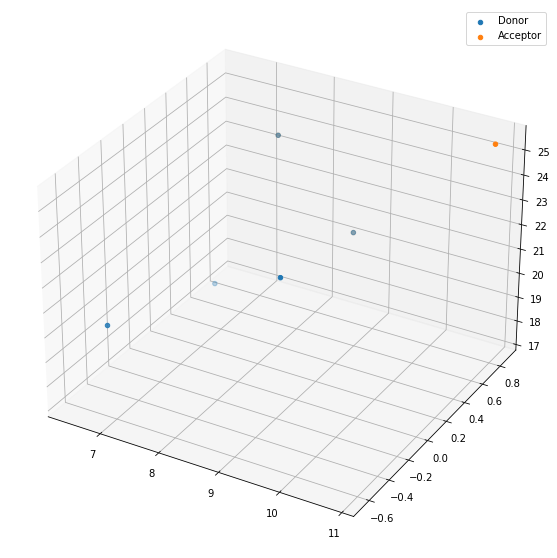

In [65]:
print(query_mols[36])
# get ph4 coords for mol
query_donor_coords, query_acceptor_coords, query_aromatic_coords = get_coords_query(query_mols[36])

# plot
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

labels = ['Donor', 'Acceptor', 'Aromatic']
for coords, label in zip([query_donor_coords, query_acceptor_coords, query_aromatic_coords], labels):
    if coords is not None:
        ax.scatter3D(coords[:,0], coords[:,1], coords[:,2], label=label)

plt.legend()
plt.show()

# NOTE look at how to plot from list of dicts


substructure matching

- remove query molecules similar to fragments?
- remove query molecules similar to each-other?

alignment:

https://zpl.fi/aligning-point-patterns-with-kabsch-umeyama-algorithm/
trying to use my kabsch functions to align query to fragment cloud:

In [ ]:
import sabs_kabsch.kabsch_functions as kabsch

query_points = np.concatenate([query_pharma_dict['Donor'], query_pharma_dict['Acceptor']])
pocket_points = np.concatenate([frag_donor_coords, frag_acceptor_coords])

query_points = np.array([query_points[0:,], query_points[1:,], query_points[2:,]], dtype='object')
pocket_points = np.array([pocket_points[0:,], pocket_points[1:,], pocket_points[2:,]], dtype='object')

qm_trans, qm_means = kabsch.translate_to_origin(query_points)
frm_trans, frm_means = kabsch.translate_to_origin(pocket_points)
h = kabsch.compute_covariance_matrix(qm_trans, frm_trans)
r = kabsch.compute_optimal_rotation_matrix(h)
qm_rotated = kabsch.apply_rotation(qm_trans, r)
qm_reverted, frm_reverted = kabsch.revert_translation(qm_rotated, frm_trans, qm_means, frm_means)


ax = plt.figure(figsize=(15,15)).add_subplot(projection='3d')

# plot matrices for comparison 
ax.plot(qm_reverted[0], qm_reverted[1], qm_reverted[2], label='Query', color='r')
ax.plot(frm_reverted[0], frm_reverted[1], frm_reverted[2], label='Fragments', color='b')

# set plot titles and labels
ax.legend(loc='upper left', fontsize=20)
ax.set_xlabel('X', fontsize=20)
ax.set_ylabel('Y', fontsize=20)
ax.set_zlabel('Z', fontsize=20)
plt.title('Test query mapped to fragments', fontsize=20)